In [1]:
import datalog  as dl
import pandas as pd
import numpy as np

def read_wpilog(filename):
    data = dl.wpilog_to_json(filename)
    df = pd.DataFrame(data)
    return df

# df = read_wpilog('newdump/FRC_20220330_210122.wpilog')
df = read_wpilog('autons/FRC_20220331_001608.wpilog')
# df = read_wpilog('newdump/FRC_20220330_213451.wpilog')
# Remove the standard data fields, only keeping our custom data.
df = df[df['name'].apply(lambda x: not x.startswith('NT:/') and x != 'NTConnection' and x != 'messages')]
# Verify we've got only what we need
df['name'].unique()


array(['accelX', 'accelY', 'accelZ', 'target X', 'target Y', 'pose X',
       'pose Y', 'error X', 'error Y', 'is notifier stopped',
       'target heading', 'pose heading'], dtype=object)

In [2]:
# Now we create a rownum column that will take every variable we're logging,
# group them together and internally sort that group by the timestamp value and
# create an increasing row number for each group.
# This in effect ranks the first target X witha rownum=1, the first target Y with a rownum=1
# and so on down the line of columns, then rownum=2 contains the second value for each variable.
df['rownum'] = df.sort_values(by='timestamp').groupby('name').cumcount() + 1

# Now for each rownum we create new columns that shows us the minimum, or
# first timestamp value in that rownum as well as max/last and the difference
# between them. If the time difference is too large (subjective) we might want to consider
# dropping an incomplete row of data or adjusting our technique for lining them up.
df['mints'] = df.groupby('rownum')['timestamp'].transform('min')
df['maxts'] = df.groupby('rownum')['timestamp'].transform('max')
df['avgts'] = df.groupby('rownum')['timestamp'].transform('mean')
df['diffts'] = df['maxts'] - df['mints']

# Look for the rows with the largest difference.
# (This is how I figured out we should drop messages from the data)
timecheck_df = df.sort_values(by='diffts', ascending=False)
timecheck_df.head()

,name,type,timestamp,value,rownum,mints,maxts,avgts,diffts
11208,error Y,double,14.968300,0.255164,248,14.968263,16.850305,15.282312,1.882042
13410,target heading,double,16.850301,30.0,248,14.968263,16.850305,15.282312,1.882042
11200,accelX,double,14.968263,0.0,248,14.968263,16.850305,15.282312,1.882042
11201,accelY,double,14.968271,0.0,248,14.968263,16.850305,15.282312,1.882042
11202,accelZ,double,14.968277,0.0,248,14.968263,16.850305,15.282312,1.882042


In [3]:
# Currently the df dataframe has a single 'name' column and a single 'value' column
# that is a mix of everything we're measuring. Here we take each value for 'name'
# (target X, target Y, etc.. ) and turn them into a column with ther row's 'value'
# as the value of the cell
pivot_df = df.pivot(index='rownum', columns='name', values='value')
pivot_df['pose error'] = (pivot_df['pose heading']-pivot_df['target heading']).abs()
pivot_df.head()


name,accelX,accelY,accelZ,error X,error Y,is notifier stopped,pose X,pose Y,pose heading,target X,target Y,target heading,pose error
rownum,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,False,297.796121,30.497013,80.448151,297.796121,30.497013,45.0,35.448151
2,0.0,0.0,0.0,0.000938,-0.015675,False,297.796121,30.497013,80.447815,297.797059,30.481338,45.0,35.447815
3,0.0,0.0,0.0,0.000776,-0.022055,False,297.796121,30.497013,80.447815,297.796897,30.474958,45.0,35.447815
4,0.0,0.0,0.0,-0.000487,-0.01914,False,297.796121,30.497013,80.449799,297.795634,30.477873,45.0,35.449799
5,0.0,0.0,0.0,-0.002851,-0.00693,False,297.796121,30.497013,80.449799,297.79327,30.490084,45.0,35.449799


In [4]:
# Trim our original dataframe down to just the rownum and timestamp values
ts_df = df[['rownum', 'mints', 'maxts', 'avgts', 'diffts']]
ts_df = ts_df.drop_duplicates()

# Join the timestamp data back to our pivoted dataset so we've got that available in a single dataframe
# The ts_df dataframe is basically a spreadsheet with rownum and the timestamp values for each as the columns
# The pivot_df also contains the same rownum value, but it is already naturally its index
# and Panads joins on indexes without fuss, so we index the ts_df to the rownum column it has
# and let pandas join them up. Think of it like making two spreadsheets and copying and pasting
# them together and it works because they're ordered the same way with the same number of rows.
full_df = ts_df.set_index('rownum').join(pivot_df)

# Fill forward any NaN (null) values that are still in the data. This basically says to
# use the last known value for a column, like target X, if NaN was reported in this time slot
full_df = full_df.ffill()
# full_df

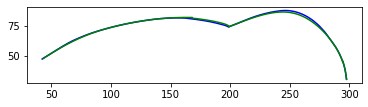

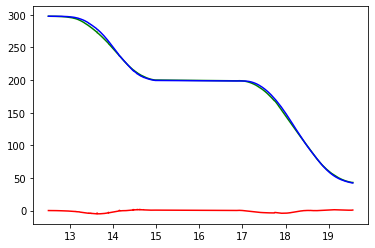

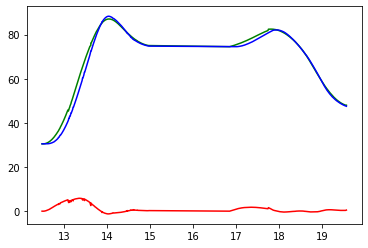

In [5]:
import matplotlib.pyplot as plt

plt.plot(full_df['pose X'], full_df['pose Y'], c='b')
plt.plot(full_df['target X'], full_df['target Y'], c='g')
plt.gca().set_aspect(1)
plt.show()

#plt.plot(full_df['target X'], full_df['target Y'])
plt.plot(full_df['mints'], full_df['error X'], c='r')
plt.plot(full_df['mints'], full_df['target X'], c='g')
plt.plot(full_df['mints'], full_df['pose X'], c='b')
plt.show()

plt.plot(full_df['mints'], full_df['error Y'], c='r')
plt.plot(full_df['mints'], full_df['target Y'], c='g')
plt.plot(full_df['mints'], full_df['pose Y'], c='b')
plt.show()


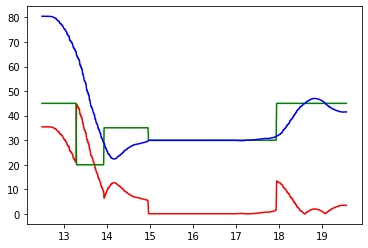

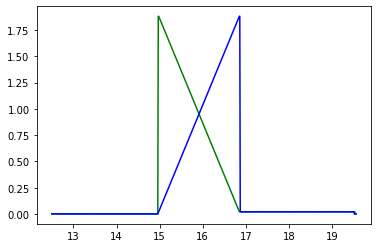

In [6]:

plt.plot(full_df['mints'], full_df['pose error'], c='r')
plt.plot(full_df['mints'], full_df['target heading'], c='g')
plt.plot(full_df['mints'], full_df['pose heading'], c='b')
plt.show()
plt.plot(full_df['mints'], full_df['diffts'], c='g')
plt.plot(full_df['maxts'], full_df['diffts'], c='b')
plt.show()

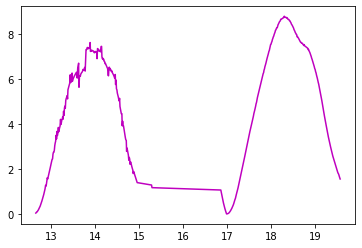

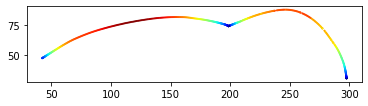

In [7]:
tmpdf = full_df
tmpdf['deltaX'] = (tmpdf['pose X']-tmpdf['pose X'].shift(1)).abs()
tmpdf['deltaY'] = (tmpdf['pose Y']-tmpdf['pose Y'].shift(1)).abs()
tmpdf['distance'] = np.sqrt(tmpdf['deltaX']**2 + tmpdf['deltaY']**2)
tmpdf['velocity'] = tmpdf['distance']/(tmpdf['avgts']-tmpdf['avgts'].shift(1))
tmpdf['velocity_fps'] = tmpdf['velocity']/12
tmpdf['velocity_fps_avg'] = tmpdf['velocity_fps'].rolling(16).mean()

tmpdf['deltaVelocity'] = tmpdf.velocity - tmpdf.velocity.shift(1)
tmpdf['acceleration'] = tmpdf.deltaVelocity / (tmpdf.mints - tmpdf.mints.shift(1))  # In inches/sec/sec

plt.plot(tmpdf['avgts'], tmpdf['velocity_fps_avg'], c='m')
plt.show()

plt.scatter(tmpdf['pose X'], tmpdf['pose Y'], s=1, c=tmpdf.velocity_fps_avg, cmap='jet')
plt.gca().set_aspect(1)
plt.show()

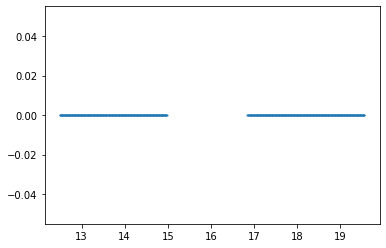

In [9]:
plt.scatter(tmpdf.mints, tmpdf.accelY, s=1)
plt.show()